In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent as AgentDQN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.agent.lstm import Agent as AgentLSTM
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from rex import init_logger
from sympy import symbols, sqrt, simplify, expand, nsimplify, parse_expr, sympify
import sympy
import cProfile, pstats, io
from pstats import SortKey

In [4]:
init_logger(__name__, log_level='INFO')
init_logger('rl_equation_solver', log_level="INFO")

<Logger rl_equation_solver (INFO)>

## Run agent until solution is found a single time for sets of hyperparameters ##

In [21]:
from concurrent.futures import ThreadPoolExecutor, as_completed

soln_steps = {}
configs = {}
taus = [0.7, 0.85, 1.0]
gammas = [0.7, 0.8, 0.9]
eps_start = [0.9, 0.7, 0.5]
run_number = 20
max_workers = 32

count = 0
for tau in taus:
    for gamma in gammas:
        for eps in eps_start:
            config = {'tau': tau, 'gamma': gamma, 'eps_start': eps}
            configs[count] = config
            count += 1

for i in range(len(configs)):
    soln_steps[i] = [0] * run_number

def find_soln(i, j):
    config = configs[i]
    env = Env(order=2, config={'reward_function': 'diff_loss_reward'})
    agent = AgentGCN(env, device='cuda:0', config=config)
    agent.find_solution()
    soln_steps[i][j] = env.solution_steps

def run_pool():
    futures = {}
    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        for i in range(len(configs)):
            for j in range(run_number):
                future = pool.submit(find_soln, i, j)
                futures[future] = (i, j)

        for _, future in enumerate(as_completed(futures)):
            _ = future.result()
            i, j = futures[future]
            print(f'future {(i, j)} completed')  


In [22]:
run_pool()

INFO - 2023-04-18 14:57:10,811 [algebraic.py:115] : Initializing environment with order=2, |S| = 11 x 128 = 1408
INFO - 2023-04-18 14:57:10,813 [algebraic.py:118] : Using reward function: diff_loss_reward.
INFO - 2023-04-18 14:57:10,814 [algebraic.py:115] : Initializing environment with order=2, |S| = 11 x 128 = 1408
INFO - 2023-04-18 14:57:10,814 [base.py:69] : Initialized Agent with config: {'batch_size': 16, 'gamma': 0.7, 'eps_start': 0.9, 'eps_end': 0.05, 'eps_decay_steps': 1000, 'eps_decay': None, 'tau': 0.7, 'learning_rate': 0.0001, 'hidden_size': 64, 'memory_cap': 10000, 'reset_steps': 100, 'state_dim': 128, 'feature_num': 100, 'grad_clip': 100, 'reward_function': 'diff_loss_reward'}
INFO - 2023-04-18 14:57:10,816 [algebraic.py:115] : Initializing environment with order=2, |S| = 11 x 128 = 1408
INFO - 2023-04-18 14:57:10,817 [algebraic.py:115] : Initializing environment with order=2, |S| = 11 x 128 = 1408
INFO - 2023-04-18 14:57:10,817 [algebraic.py:118] : Using reward function:

c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\agent\base.py:291: RuntimeWarning: Mean of empty slice
  mean_loss = np.nanmean(self.history[current_episode]['loss'])


INFO - 2023-04-18 14:57:10,938 [base.py:69] : Initialized Agent with config: {'batch_size': 16, 'gamma': 0.7, 'eps_start': 0.9, 'eps_end': 0.05, 'eps_decay_steps': 1000, 'eps_decay': None, 'tau': 0.7, 'learning_rate': 0.0001, 'hidden_size': 64, 'memory_cap': 10000, 'reset_steps': 100, 'state_dim': 128, 'feature_num': 100, 'grad_clip': 100, 'reward_function': 'diff_loss_reward'}
INFO - 2023-04-18 14:57:10,939 [gcn.py:37] : Initialized Agent with device cuda:0
INFO - 2023-04-18 14:57:10,940 [base.py:69] : Initialized Agent with config: {'batch_size': 16, 'gamma': 0.7, 'eps_start': 0.9, 'eps_end': 0.05, 'eps_decay_steps': 1000, 'eps_decay': None, 'tau': 0.7, 'learning_rate': 0.0001, 'hidden_size': 64, 'memory_cap': 10000, 'reset_steps': 100, 'state_dim': 128, 'feature_num': 100, 'grad_clip': 100, 'reward_function': 'diff_loss_reward'}
INFO - 2023-04-18 14:57:10,967 [base.py:69] : Initialized Agent with config: {'batch_size': 16, 'gamma': 0.7, 'eps_start': 0.9, 'eps_end': 0.05, 'eps_decay_

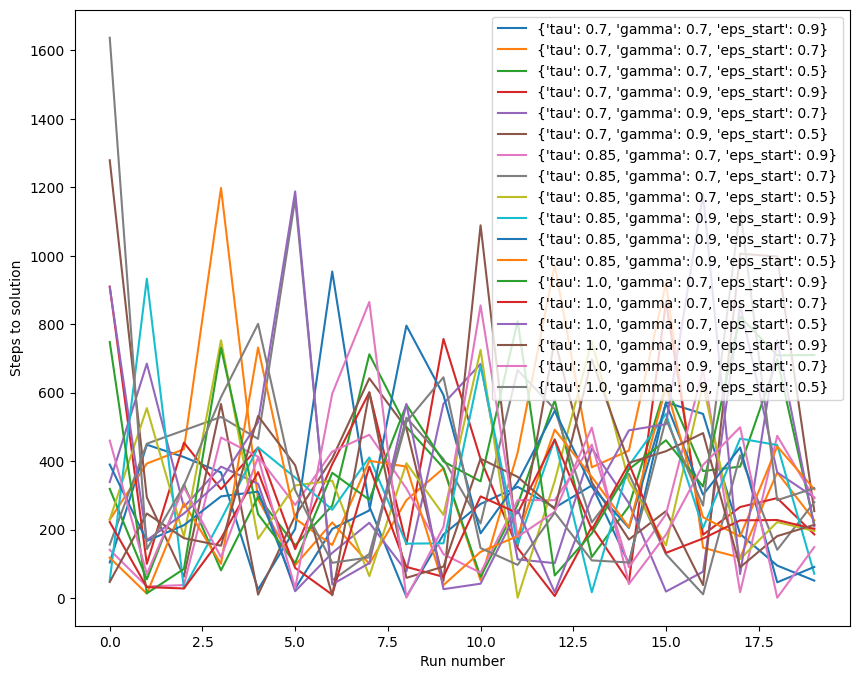

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, config in configs.items():
    ax.plot(soln_steps[i], label=str(config))
ax.set_ylabel('Steps to solution')
ax.set_xlabel('Run number')
plt.legend()

In [24]:
avgs = {k: np.mean(soln_steps[k]) for k in soln_steps}

In [25]:
configs[np.argmin(list(avgs.values()))]

{'tau': 1.0, 'gamma': 0.7, 'eps_start': 0.7}